In [50]:

from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from minisom import MiniSom
import numpy as np
import pandas as pd

In [51]:
df = pd.read_csv('./data/merged.csv')
df.drop('Index', axis=1, inplace=True)
df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,190,191,192,193,194,195,196,197,198,199
0,0.029291,0.122669,0.078690,0.509404,0.257012,0.000000,0.0,0.0,0.0,0.0,...,-0.068914,0.165855,-0.139714,0.018813,0.186408,0.246452,0.127322,0.037057,0.035583,-0.192175
1,0.072681,0.114266,0.434530,0.297216,0.072028,0.000000,0.0,0.0,0.0,0.0,...,0.164396,-0.031148,-0.016781,-0.069668,0.120217,0.086646,0.081417,-0.013408,-0.056917,-0.052905
2,0.532546,0.181123,0.050537,0.051361,0.069668,0.113055,0.0,0.0,0.0,0.0,...,-0.125470,0.051412,0.059226,-0.057874,0.426521,-0.072455,0.080208,0.068673,-0.240681,-0.269405
3,0.269257,0.163069,0.563442,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.310030,-0.218989,-0.077160,-0.038774,0.162210,-0.052915,0.167200,0.059254,0.039290,0.134820
4,0.045626,0.066652,0.133848,0.193264,0.556775,0.000000,0.0,0.0,0.0,0.0,...,0.268552,0.212245,0.184841,0.022134,0.108727,-0.105548,0.056528,0.068675,0.005168,0.110122


In [52]:
# Convert Nan values to 0 in each column
df = df.fillna(0)
# Check if there are any Nan values left
df.isnull().sum()

topic_0    0
topic_1    0
topic_2    0
topic_3    0
topic_4    0
          ..
195        0
196        0
197        0
198        0
199        0
Length: 220, dtype: int64

In [53]:
def get_user_input():
    doc_index = int(input("Enter the document index (0 to 17999): "))
    num_neighbors = int(input("Enter the number of neighbors: "))
    return doc_index, num_neighbors

In [54]:
def fit_knn_model(features):
    knn = NearestNeighbors(n_neighbors=features.shape[0])  # Use maximum number of neighbors
    knn.fit(features)
    return knn

In [55]:
def get_nearest_neighbors(knn, features, doc_index, num_neighbors):
    distances, indices = knn.kneighbors(features.iloc[doc_index].values.reshape(1, -1), n_neighbors=num_neighbors + 1)
    # Exclude the first neighbor as it is the document itself
    return indices.flatten()[1:], distances.flatten()[1:]

In [67]:
 knn_model = fit_knn_model(df)
# Get user input
doc_index, num_neighbors = get_user_input()
    
# Get nearest neighbors
neighbor_indices, neighbor_distances = get_nearest_neighbors(knn_model, df, doc_index, num_neighbors)
    
# Retrieve the nearest neighbors from the original DataFrame
neighbors_df = df.iloc[neighbor_indices].copy()
neighbors_df['Distance'] = neighbor_distances
neighbors_df.head()
neighbors_df.shape

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


(500, 221)

In [68]:
k = 3
som_shape = (1,k)

# Extract features for SOM training (excluding 'Distance' column)
features_for_som = neighbors_df.drop(columns=['Distance']).values

# Initialize and train SOM
som = MiniSom(som_shape[0], som_shape[1], features_for_som.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)
som.train_batch(features_for_som, 1000, verbose=True)

# Assign each data point to a cluster
win_map = som.win_map(features_for_som)
cluster_index = np.zeros(features_for_som.shape[0], dtype=int)

for i, x in enumerate(features_for_som):
    w = som.winner(x)
    cluster_index[i] = w[1]  # since som_shape is (1, k), we use the second index

# Display cluster assignment for each data point
neighbors_df['cluster'] = cluster_index
#neighbors_df = neighbors_df.drop(columns=['Distance'])
neighbors_df.head()

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.11478276584820861


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,192,193,194,195,196,197,198,199,Distance,cluster
2918,0.459027,0.459131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.016488,-0.017896,0.027829,0.037627,0.030688,-0.010304,-0.002460,0.011966,0.305911,2
2718,0.584270,0.359298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.032305,-0.009230,0.017864,-0.002502,-0.026982,0.035110,-0.006627,-0.004871,0.325539,2
3945,0.608382,0.356999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.001384,0.011534,-0.005194,0.009144,0.008504,-0.029300,0.043143,0.014802,0.327672,2
2655,0.445534,0.470563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.011533,-0.003751,0.031443,0.012999,0.020501,0.004201,-0.024174,-0.012385,0.336280,2
1318,0.710713,0.246424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000629,-0.002788,-0.001184,0.008058,0.007668,-0.007671,-0.024231,-0.002704,0.341425,1


In [69]:
preprocessed = pd.read_csv('./Data/preprocessed_final.csv')


cluster_0_df = neighbors_df[neighbors_df['cluster'] == 0]
indices_cluster_0 = cluster_0_df.index
result_df = pd.DataFrame({'Index': indices_cluster_0, 'Cluster': 0})
result_df = result_df.reset_index(drop=True)
cluster0 = result_df.merge(preprocessed[['processed_text', 'label']], left_on='Index', right_index=True, how='left')
print(cluster0)



     Index  Cluster                                     processed_text  \
0     6336        0         hi- anybody know ticket info fenway thanks   
1     8819        0                            assume sarcastic remark   
2    16428        0  anyone know anything group info would apprecia...   
3    14748        0  religion cult got co-opted people better compa...   
4    11670        0  nope david jpl-devvax.jpl.nasa.gov david smyth...   
..     ...      ...                                                ...   
216   6570        0  religion certainly benefit combat situation be...   
217   5697        0  annoying actually using one talking sitting on...   
218   6009        0  note gritz populist party ticket david duke ve...   
219  17118        0  saw picture '94 mustang popular mechanic disap...   
220  11798        0  selling global village teleport 2400 bps modem...   

                        label  
0          rec.sport.baseball  
1            rec.sport.hockey  
2      soc.reli

In [70]:
cluster_1_df = neighbors_df[neighbors_df['cluster'] == 1]
indices_cluster_1 = cluster_1_df.index
result_df = pd.DataFrame({'Index': indices_cluster_1, 'Cluster': 1})
result_df = result_df.reset_index(drop=True)
cluster1 = result_df.merge(preprocessed[['processed_text', 'label']], left_on='Index', right_index=True, how='left')
print(cluster1)

     Index  Cluster                                     processed_text  \
0     1318        1  perhaps iranian arab even not-so-strictly-spea...   
1    11587        1  quoting strnlght netcom.com david sternlight a...   
2    11526        1  anyone know twin game broadcast good ole ames ...   
3     8183        1  anyone idea get japanese league stats regularl...   
4    18598        1  curiousity old worden ________________________...   
..     ...      ...                                                ...   
248  11329        1  john take time rebut point point suggest three...   
249  18410        1  anyone know possible cause nasoparynx carcenom...   
250   6251        1  return_place probably incorrect pointer intege...   
251   4546        1  driver updated available directly diamond even...   
252   7903        1  yip problem fix found link static client btw used   

                       label  
0      talk.politics.mideast  
1                  sci.crypt  
2         rec.spor

In [71]:
cluster_2_df = neighbors_df[neighbors_df['cluster'] == 2]
indices_cluster_2 = cluster_2_df.index
result_df = pd.DataFrame({'Index': indices_cluster_2, 'Cluster': 2})
result_df = result_df.reset_index(drop=True)
cluster2 = result_df.merge(preprocessed[['processed_text', 'label']], left_on='Index', right_index=True, how='left')
print(cluster2)

    Index  Cluster                                     processed_text  \
0    2918        2                      please subscribe mailing list   
1    2718        2                                     yep called os2   
2    3945        2                          could speak n't hear ....   
3    2655        2                                          whatta as   
4    3433        2                      trry skywatch project arizona   
5    4183        2                                   surprise shocked   
6    1653        2                     imaginative least would theory   
7    1810        2        reposted without permission rec.music.dylan   
8    1295        2   've taken comp.windows.misc they're coming berry   
9    1963        2                    paul reason many colony founded   
10    263        2         idea relief sciatica please respond e-mail   
11   3763        2  got several answer complete errol crary errolc...   
12   3441        2         sound similar something 

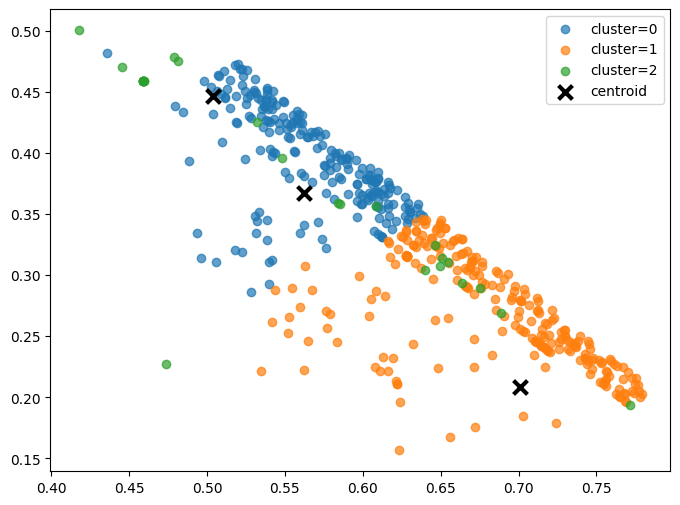

In [72]:
plt.figure(figsize=(8, 6))
for c in np.unique(cluster_index):
    plt.scatter(features_for_som[cluster_index == c, 0],
                features_for_som[cluster_index == c, 1], label='cluster=' + str(c), alpha=.7)

# Plotting centroids
centroids = som.get_weights().reshape(-1, features_for_som.shape[1])
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x',
            s=100, linewidths=3, color='k', label='centroid')
plt.legend()
plt.show()


## Cluster Evalution

In [73]:
empty_clusters = [c for c in range(k) if np.sum(cluster_index == c) == 0]
print(f"Empty clusters: {empty_clusters}")

if len(empty_clusters) == 0:  # Compute only if there are no empty clusters
    silhouette_avg = silhouette_score(features_for_som, cluster_index)
    print(f"Silhouette Coefficient: {silhouette_avg}")
else:
    print("Cannot compute silhouette score due to empty clusters.")

Empty clusters: []
Silhouette Coefficient: 0.44436096995976376


In [74]:
if len(empty_clusters) == 0:  # Compute only if there are no empty clusters
    ch_score = calinski_harabasz_score(features_for_som, cluster_index)
    print(f"Calinski-Harabasz Index: {ch_score}")
else:
    print("Cannot compute Calinski-Harabasz Index due to empty clusters.")

Calinski-Harabasz Index: 323.0428549602052


In [75]:
# put all the columns of the neighbors_df in the X variable except the cluster column
features = neighbors_df.drop(columns=['cluster','Distance'])
cluster_labels = neighbors_df['cluster'] 


In [76]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_Train, X_Test, Y_Train, Y_Test = train_test_split(features, cluster_labels, test_size=0.2, random_state=42)

# Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_Train, Y_Train)
random_forest_preds = clf.predict(X_Test)
print('The accuracy of the Random Forests model is :\t',metrics.accuracy_score(random_forest_preds,Y_Test))

The accuracy of the Random Forests model is :	 1.0


Cluster 0


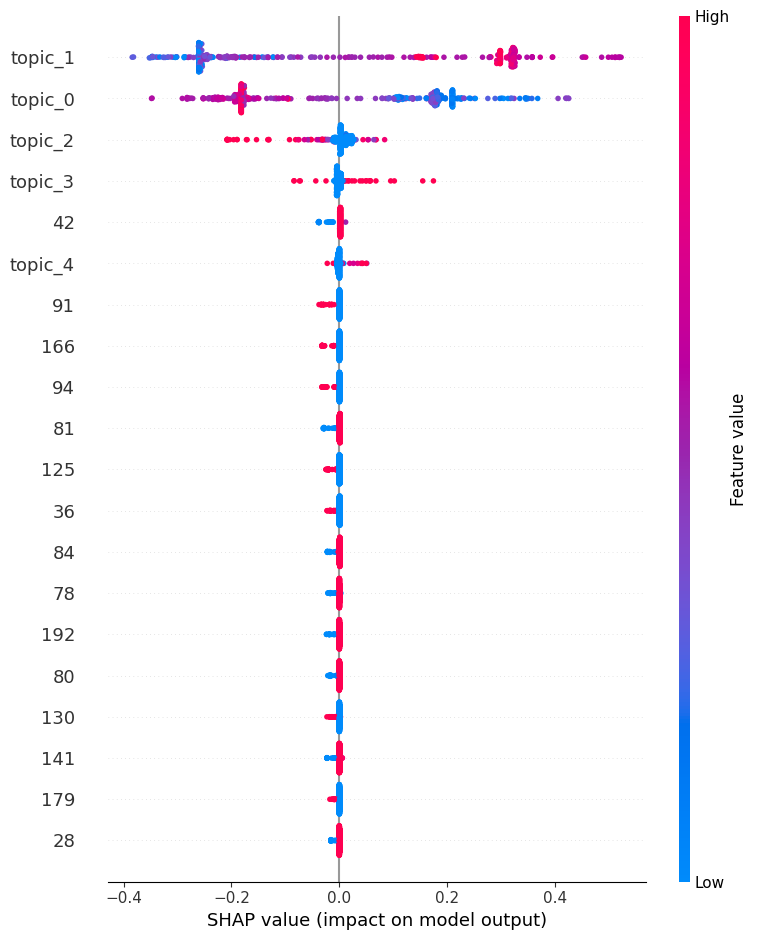

Cluster 1


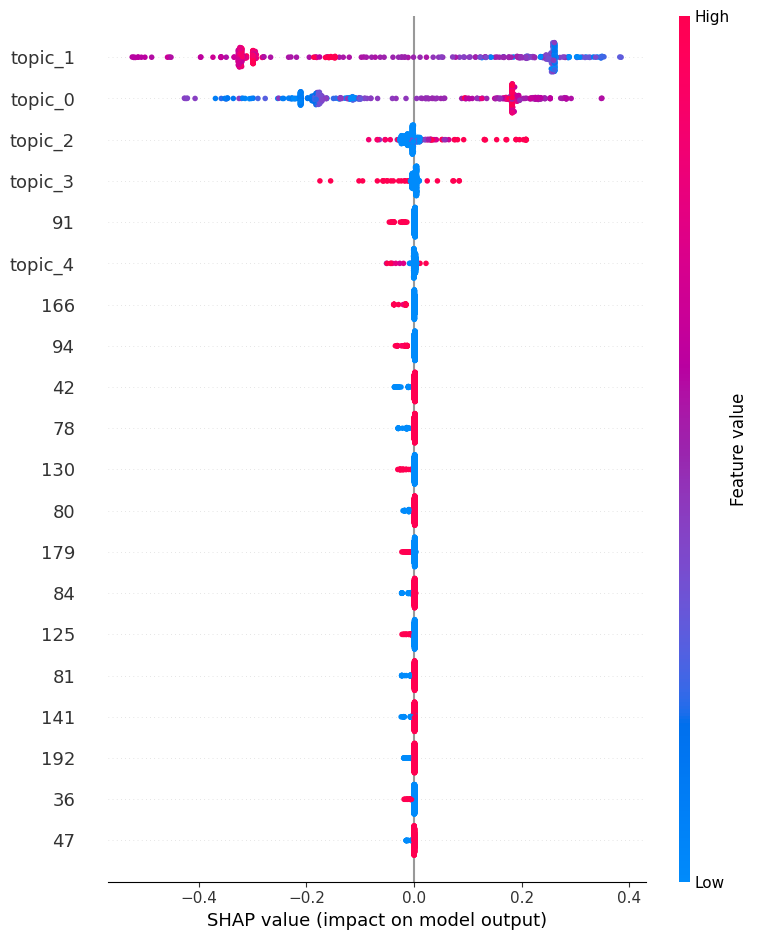

Cluster 2


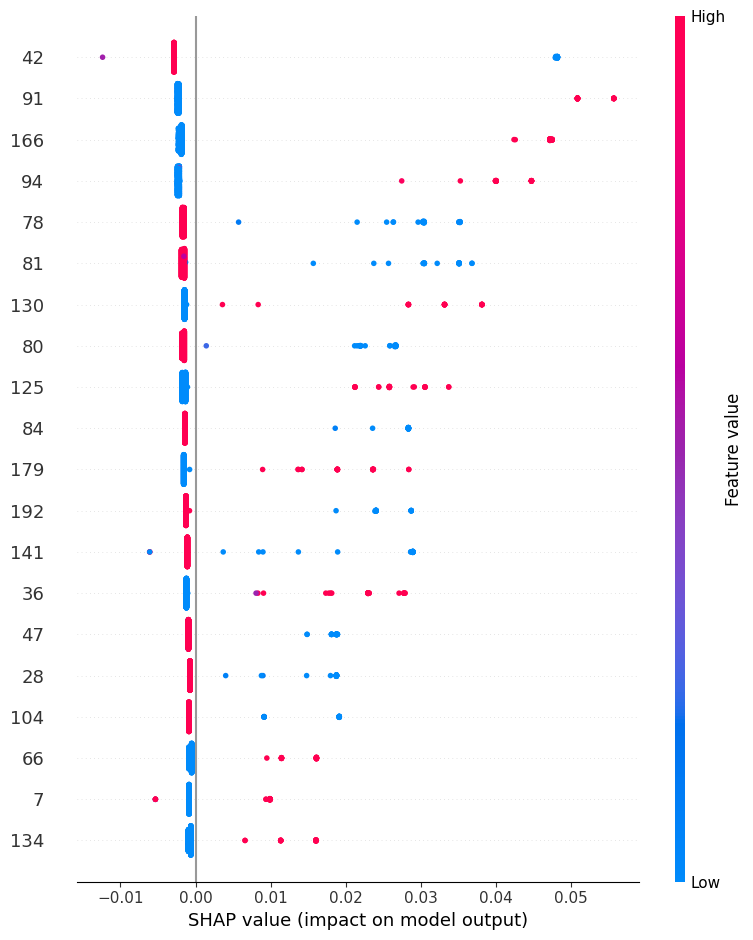

Cluster 0


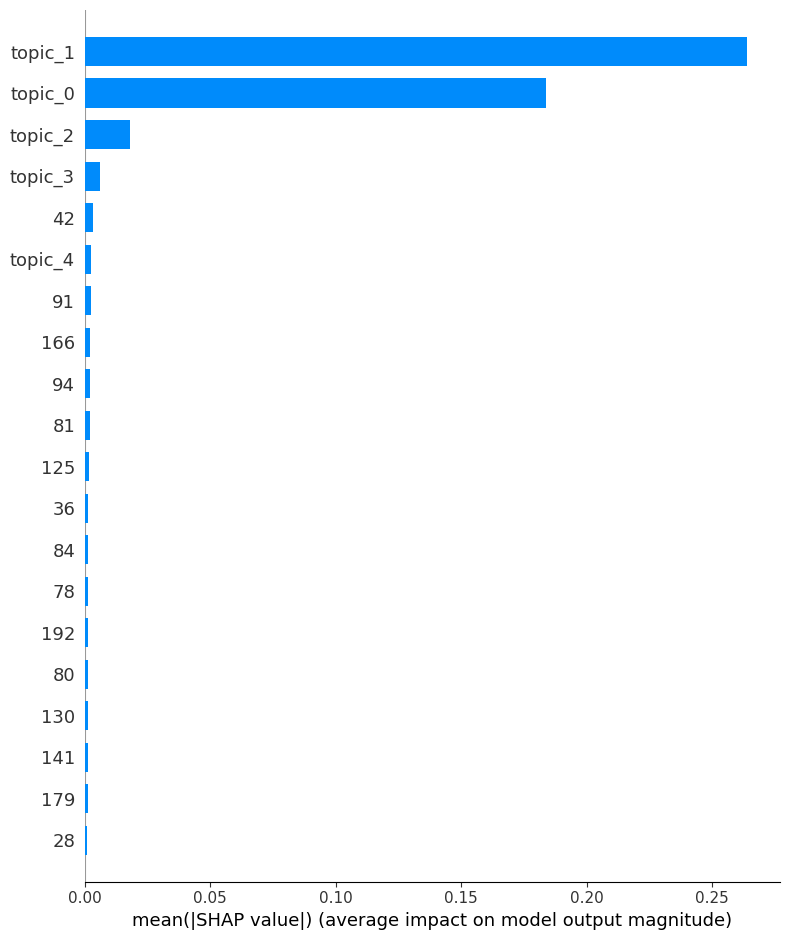

Cluster 1


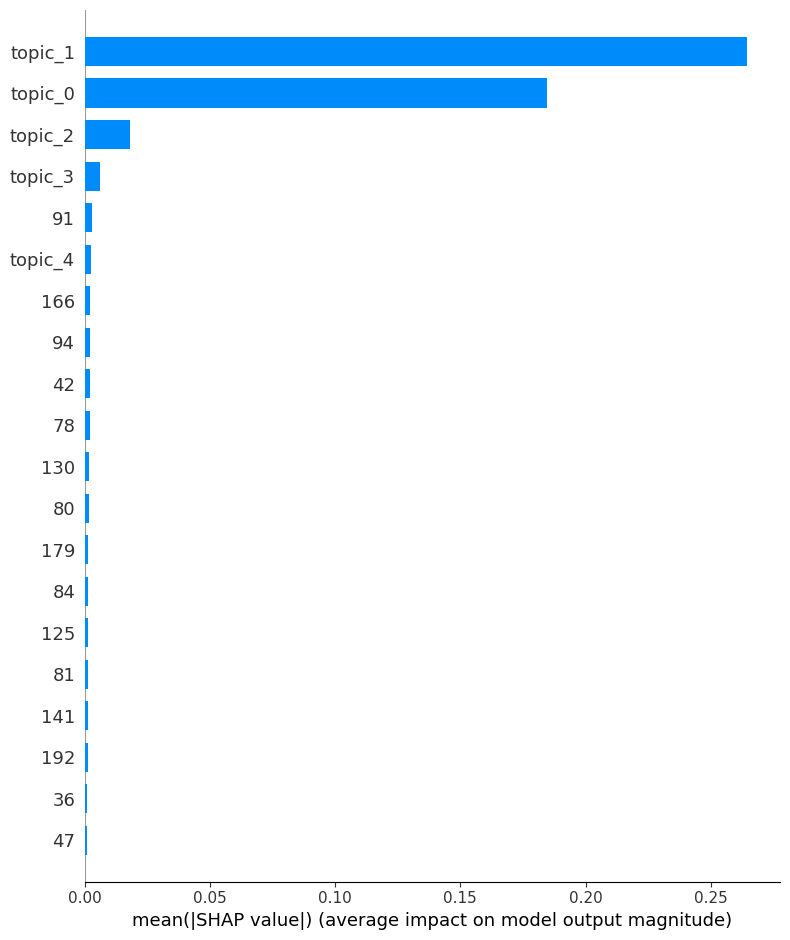

Cluster 2


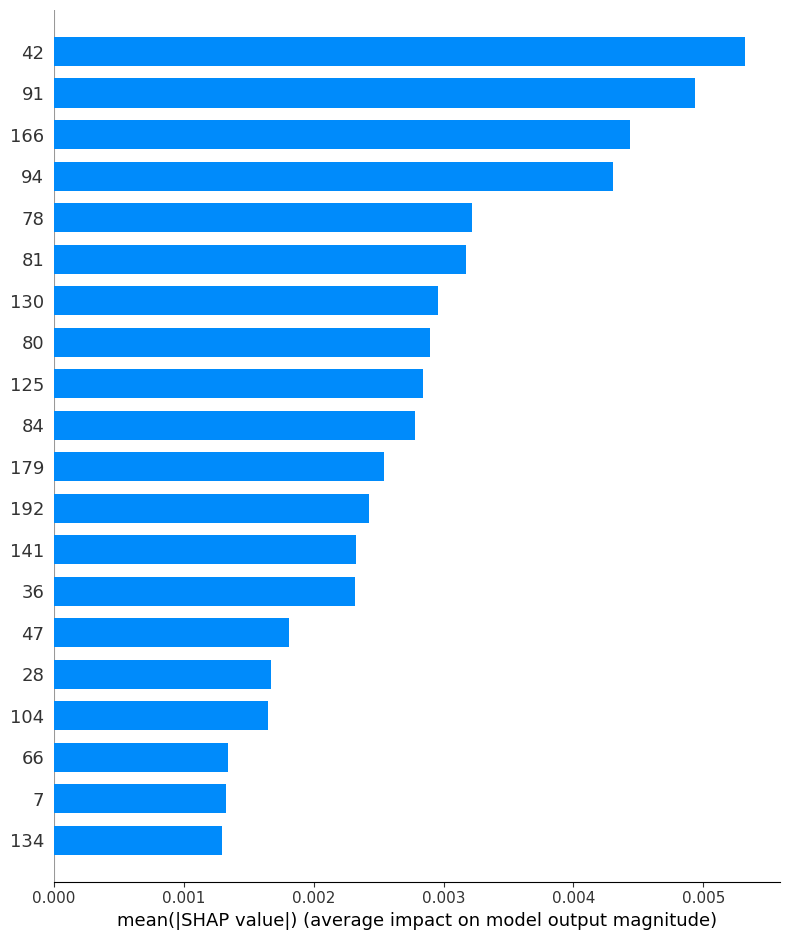

In [77]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(features)
shap_values.shape

shap_values_ = shap_values.transpose((2,0,1))

for i in range(k):
    print(f"Cluster {i}")
    shap.summary_plot(shap_values_[i], features)
    plt.show()
for i in range(k):
    print(f"Cluster {i}")
    shap.summary_plot(shap_values_[i], features, plot_type='bar')
    plt.show()


In [78]:
topics = pd.read_csv('./Data/topics.csv')
def get_topic_words(topic_id):
    top = topics['Words'][topic_id].split(',')
    topic = []
    for i in top:
        i = i.lstrip()
        topic.append(i)
    return topic

In [84]:
topic1 = get_topic_words(1)
topic0 = get_topic_words(0)
topic2 = get_topic_words(2)
topic3 = get_topic_words(3)
topic4 = get_topic_words(4)
print("Topic 0:", topic0)
print("Topic 1:", topic1)
print("Topic 2:", topic2)
print("Topic 3:", topic3)
print("Topic 4:", topic4)

Topic 0: ['one', 'jew', 'also', 'people', 'aid', 'time', 'land', 'arm', 'since', 'prophet', 'bank', 'new', 'civilian', 'would', 'turk', 'physician', 'state', 'may', 'found', 'area']
Topic 1: ['key', 'message', 'email', 'copy', 'post', 'one', 'nsa', 'algorithm', 'encryption', 'know', 'looking', 'clipper', 'sale', 'do', 'get', 'use', 'mail', 'list', 'thanks', 'faq']
Topic 2: ['son', 'apartment', 'article', 'tape', 'want_know', 'neighbor', 'mormon', 'phone', 'pipe', 'didnt_know', 'two', 'speaker', 'white', 'judge', 'aclu', 'joseph', 'cap', 'functionality', 'marked', 'parameter']
Topic 3: ['use', 'bit', 'problem', 'window', 'one', 'get', 'using', 'also', 'time', 'help', 'line', 'could', 'need', 'make', 'work', 'system', 'color', 'application', 'like', 'mode']
Topic 4: ['god', 'one', 'say', 'people', 'would', 'christian', 'may', 'see', 'think', 'believe', 'word', 'know', 'way', 'also', 'thing', 'mean', 'religion', 'even', 'jesus', 'church']


In [47]:
def find_matching_words(text, topic_words):
    words = text.split()
    matching = [word for word in words if word in topic_words]
    return ' '.join(matching)

In [80]:
cluster1['matching_words_Topic-0'] = cluster1['processed_text'].apply(lambda x: find_matching_words(x, topic0))
cluster1['matching_words_Topic-1'] = cluster1['processed_text'].apply(lambda x: find_matching_words(x, topic1))
cluster1['matching_words_Topic-2'] = cluster1['processed_text'].apply(lambda x: find_matching_words(x, topic2))
cluster1['matching_words_Topic-3'] = cluster1['processed_text'].apply(lambda x: find_matching_words(x, topic3))
cluster1['matching_words_Topic-4'] = cluster1['processed_text'].apply(lambda x: find_matching_words(x, topic4))

In [81]:
cluster1


,Index,Cluster,processed_text,label,matching_words_Topic-0,matching_words_Topic-1,matching_words_Topic-2,matching_words_Topic-3,matching_words_Topic-4
0,1318,1,perhaps iranian arab even not-so-strictly-spea...,talk.politics.mideast,,,,,even
1,11587,1,quoting strnlght netcom.com david sternlight a...,sci.crypt,,,article,,
2,11526,1,anyone know twin game broadcast good ole ames ...,rec.sport.baseball,,know,,,know
3,8183,1,anyone idea get japanese league stats regularl...,rec.sport.baseball,,get,,get,
4,18598,1,curiousity old worden ________________________...,sci.space,,,,,
...,...,...,...,...,...,...,...,...,...
248,11329,1,john take time rebut point point suggest three...,soc.religion.christian,time also also new,get,two,time work also work also work like get,think religion also jesus also christian think...
249,18410,1,anyone know possible cause nasoparynx carcenom...,sci.med,also area,know thanks,,also,know also even
250,6251,1,return_place probably incorrect pointer intege...,comp.windows.x,,copy,,,
251,4546,1,driver updated available directly diamond even...,comp.os.ms-windows.misc,,,,,even


In [82]:
cluster0['matching_words_Topic-0'] = cluster1['processed_text'].apply(lambda x: find_matching_words(x, topic0))
cluster0['matching_words_Topic-1'] = cluster1['processed_text'].apply(lambda x: find_matching_words(x, topic1))
cluster0['matching_words_Topic-2'] = cluster1['processed_text'].apply(lambda x: find_matching_words(x, topic2))
cluster0['matching_words_Topic-3'] = cluster1['processed_text'].apply(lambda x: find_matching_words(x, topic3))
cluster0['matching_words_Topic-4'] = cluster1['processed_text'].apply(lambda x: find_matching_words(x, topic4))


In [83]:
cluster0

,Index,Cluster,processed_text,label,matching_words_Topic-0,matching_words_Topic-1,matching_words_Topic-2,matching_words_Topic-3,matching_words_Topic-4
0,6336,0,hi- anybody know ticket info fenway thanks,rec.sport.baseball,,,,,even
1,8819,0,assume sarcastic remark,rec.sport.hockey,,,article,,
2,16428,0,anyone know anything group info would apprecia...,soc.religion.christian,,know,,,know
3,14748,0,religion cult got co-opted people better compa...,alt.atheism,,get,,get,
4,11670,0,nope david jpl-devvax.jpl.nasa.gov david smyth...,comp.windows.x,,,,,
...,...,...,...,...,...,...,...,...,...
216,6570,0,religion certainly benefit combat situation be...,alt.atheism,one,one,two,one,one
217,5697,0,annoying actually using one talking sitting on...,comp.sys.ibm.pc.hardware,,know,,,know
218,6009,0,note gritz populist party ticket david duke ve...,talk.politics.guns,would one,looking list know email copy mail one list thanks,,could one could,know would one
219,17118,0,saw picture '94 mustang popular mechanic disap...,rec.autos,state would,know,joseph,like problem like system system,know say say would thing believe believe


## Siddhi's Code

In [ ]:
# # Select cluster to analyze (e.g., cluster 0)
cluster_to_analyze = 1
features_cluster = features[neighbors_df['cluster'] == cluster_to_analyze]
# print("feature cluster shape",features_cluster.shape)
shap_values_cluster = shap_values_[cluster_to_analyze][neighbors_df['cluster'].values == cluster_to_analyze,:]
# print("shape values cluster",shap_values_cluster.shape)
# # Generate summary plot for the cluster
# print(f"Cluster {cluster_to_analyze}")
shap.summary_plot(shap_values_cluster, features_cluster)
plt.show()
#
# Find the topmost feature in the SHAP summary plot
shap_importances = np.mean(np.abs(shap_values_cluster), axis=0)
# top_feature_index = np.argmax(shap_importances)
top_feature_index=204
top_feature_name = feature_names[top_feature_index]

print(f"Top feature contributing to cluster {cluster_to_analyze}: {top_feature_name}")

# Check if the top feature is an LDA feature
if top_feature_index >= 200:
    # Rank documents by the LDA value of the top feature
    lda_feature_index = top_feature_index - 200  # Adjust index for LDA features
    top_feature_values = features_cluster.iloc[:, top_feature_index]
    sorted_indices = np.argsort(top_feature_values)[::-1]
    sorted_documents = neighbors_df.index[neighbors_df['cluster'] == cluster_to_analyze][sorted_indices]

    print("Top 5 documents in Cluster sorted by top feature LDA value:")
    top_5_docs = sorted_documents[:5]
    for doc_id in top_5_docs:
        # print(f"Document ID: {doc_id}")
        print(f"Document Label: {newsgroups.target_names[newsgroups.target[doc_id]]}")
        # print(f"Document Content: {newsgroups.data[doc_id][:500]}")  # Display first 500 characters for brevity
        print("----------")
else:
    print("The top feature is not an LDA feature, cannot rank documents by LDA value.")